# ML Pipeline Preparation

### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
import numpy as np
import pandas as pd
import sys
from sqlalchemy import create_engine
import nltk
import joblib

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as iPipeline

from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to /home/salman1567/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/salman1567/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part I: Loading the Dataset

In [3]:
# load data from database
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql_table('data/DisasterResponse.db', engine)

### Method 1: Undersampling
In this method we will only take a subset of smaples from the entire dataset. Knowing this should be okay since most of the text data have similar text.


In [25]:


def underSampleDataSet(df, samples=200):
    """Returns a balanced dataset with a specified number of samples in each class.

    Args:
        df (Dataframe): Class-Imbalanced Dataset that needs to be undersampled.
        samples (int, optional): Number of samples in each class. Defaults to 200.

    Returns:
        df_balanced (Dataframe): Balanced Dataset that has been undersampled.
    """
    
    df_resampled = []
    df.drop(['child_alone'], axis=1, inplace=True)
    
    for i in df.iloc[:,4:].columns:
        new_df = df[df[i]==1]
        df_resampled.append(new_df.sample(200, replace=True))
    
    # Concating the 200 samples from each category into one and returning it.
    df_balanced = pd.concat(df_resampled)
    return df_balanced

df_undersampled = underSampleDataSet(df)




KeyError: "['child_alone'] not found in axis"

In [12]:
# check if they have been resampled
df_undersampled

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
24066,27877,WFP is also managing the fleet of rugged vehic...,None,news,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2864,3316,"In Santo 16 we have no food, help us, we're hu...","nan santo 16 nou pagen mange ede nou, nou grangou",direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4895,5589,AND IF WE CAN CH VIN Chem TO CH VIN Chem VIN...,E SI NOU KA VIN CHCHEM POU NOU VIN CHCHEM MWEN...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20336,23746,District 7020 is collecting funds to purchase ...,None,news,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
23600,27371,* Enhanced rehabilitation of irrigation scheme...,None,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4129,4733,We can't take it any more. We are located at L...,KAPAB ANK SVP EDE NOU NOU SITIYE LEYOGANE SOU ...,direct,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5414,6160,I want to remove the gabeges and the rubbles.,mwen vle retire fatra ak gravwa,direct,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2229,2580,"Logane, 9th section Citronnier. We need food.",Logane 9m section citronniers nou bezwen manje,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
12749,15316,Our town is eerily dark tonight. Never seen it...,None,social,1,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1


This dataset is imbalanced so we will try to attempt to merge some of the really small categories which have less than 200 samples. This does mean we lose some specificity with our model and this is an important consideration if this trade off is acceptable or not. It can be argued in some situations we don't need to know the exact specific disaster but rather the general category such as if it is infrastructural related we make sure we send out a team with tools and general capability to handle that kind of situation.

We will be merging buildings, electricity, tools, hospitals, shops, aid-centers, other_infrastructure all into `infrastructure_related`. The reason for doing this makes sense from a logical point of view since those are all infrastructure related and will typically mean we send out similar teams prepared for any kind of infrastructure related problems.

We will also be placing clothing, money, missing people, refugees and death category into `other_aid`



## Part II: Experimenting with Feature Engineering

Attempting to experiment with feature engineering to see if f1 score will improve by making the model more general and merging some of the indepdent features together.

In [6]:

def merge_features(df):
      """Merging specific categories into more general categories.
      Example:
            Features such as building, electricity can be considered as infrastructure_related
            Thus features like building and electricity can be dropped as the feature infrastructure_related
            already classifies those kind of problems. 
            
      Args:
          df (Dataframe): Original dataframe containing all features

      Returns:
          df_merged (Dataframe): Dataframe with merged features 
      """
      
      # If any of these features are 1 than infrastructure_related should be 1 since we merging them in
      df.loc[(df['buildings']==1) |
            (df['electricity']==1) |
            (df['tools']==1) |
            (df['hospitals']==1) |
            (df['shops']==1) |
            (df['aid_centers']==1) |
            (df['other_infrastructure']==1), 'infrastructure_related'] = 1

      # Merging categories into other aid

      df.loc[(df['clothing']==1) |
            (df['money']==1) |
            (df['missing_people']==1) |
            (df['refugees']==1) |
            (df['death']==1), 'other_aid'] = 1

      # Merging floods, storm, cold and other_weather into weather_related

      df.loc[(df['floods']==1) |
            (df['storm']==1) |
            (df['cold']==1) |
            (df['other_weather']==1), 'weather_related'] = 1

      # Dropping the features that have been merged into weather_related, other_aid and infrastructure_related
      df_merged = df.drop(labels=['buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
            'clothing', 'money', 'missing_people', 'refugees', 'death', 'floods', 'storm', 'cold', 'other_weather'], axis=1)
      
      return df_merged

# merge_features(df)

#### Feature merging

Later when running the pipeline we see that this merging improves f1 score very slightly, lowering precision but improving recall thus overall with an improved f1 score. Since we are dealing with an imbalanced dataset we will prioritize recall and f1 score over precision.

In [23]:
# Making sure that the features successfuly merged into infrastructure_related
X = df_undersampled.iloc[:,1]
Y = df_undersampled.iloc[:,4:]
total_samples = Y.shape[0]
sample_size = []

# Counting the number of samples for each category i.e each sample that is classified as 1
for i in Y.columns.unique():
    number_of_samples = Y[Y[i]==1].shape[0]
    sample_size.append(number_of_samples)
    print(i, number_of_samples, number_of_samples/total_samples,sep=" - ")

# Creating dataframe that contains the number of samples in each category
data = {"category": Y.columns.unique(), "sample_size": sample_size}
df_sample = pd.DataFrame(data=data)


related - 7000 - 1.0
request - 2031 - 0.29014285714285715
offer - 248 - 0.03542857142857143
aid_related - 5963 - 0.8518571428571429
medical_help - 1525 - 0.21785714285714286
medical_products - 1259 - 0.17985714285714285
search_and_rescue - 842 - 0.12028571428571429
security - 619 - 0.08842857142857143
military - 598 - 0.08542857142857142
water - 1082 - 0.15457142857142858
food - 1573 - 0.22471428571428573
shelter - 1614 - 0.23057142857142857
clothing - 481 - 0.06871428571428571
money - 549 - 0.07842857142857143
missing_people - 475 - 0.06785714285714285
refugees - 844 - 0.12057142857142857
death - 981 - 0.14014285714285715
other_aid - 1970 - 0.2814285714285714
infrastructure_related - 1991 - 0.2844285714285714
transport - 1177 - 0.16814285714285715
buildings - 1133 - 0.16185714285714287
electricity - 604 - 0.08628571428571429
tools - 363 - 0.05185714285714286
hospitals - 476 - 0.068
shops - 344 - 0.04914285714285714
aid_centers - 540 - 0.07714285714285714
other_infrastructure - 1074 - 

,category,sample_size
0,related,7000
1,request,2031
2,offer,248
3,aid_related,5963
4,medical_help,1525
5,medical_products,1259
6,search_and_rescue,842
7,security,619
8,military,598
9,water,1082


In [8]:
# Do the same for other aid
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
24066,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2864,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4895,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20336,1,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,1
23600,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Visualizations

Number of samples per category - displayed as a Barplot

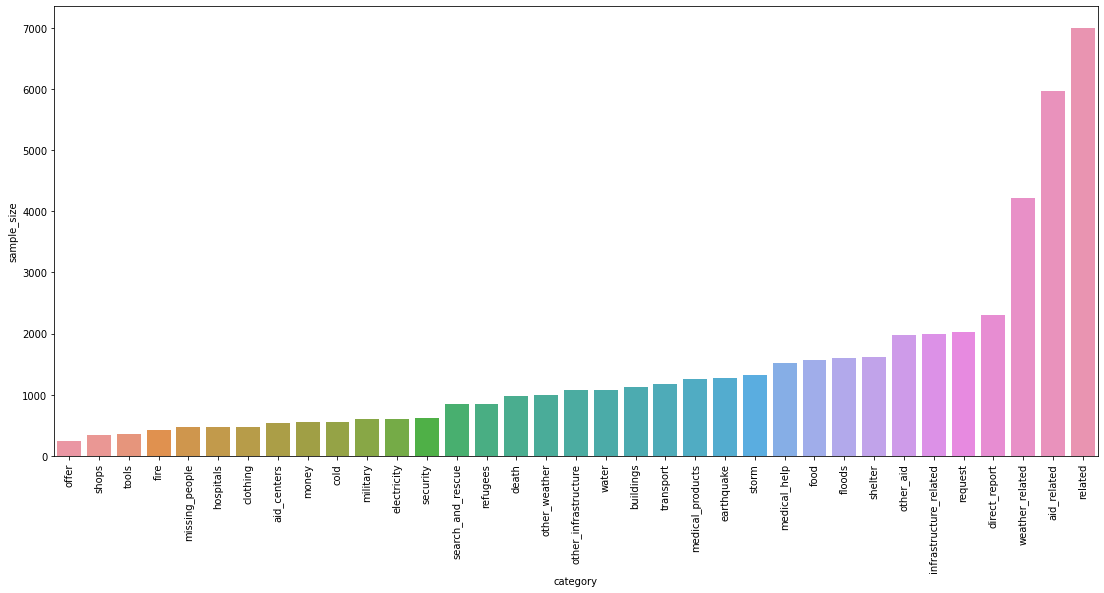

In [24]:
import seaborn as sns
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 18.7,8.27

# Displaying barplot of the number of samples in each category
hplot = sns.barplot(data=df_sample.sort_values(by='sample_size'), x="category", y="sample_size")
hplot.tick_params(axis='x', rotation=90)

## Part III: Tokenization of text data
### 2. Write a tokenization function to process your text data

In [ ]:
def tokenize(text):
    
    clean_tokens = []
    
    # lowercasing and removing punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower().strip())
    tokens = word_tokenize(text)
    
    # Remove stop words + stem
    stemmer = PorterStemmer()
    
    stop_words = stopwords.words("english")
    clean_tokens = [ stemmer.stem(word) for word in tokens if word not in stop_words]

    return clean_tokens


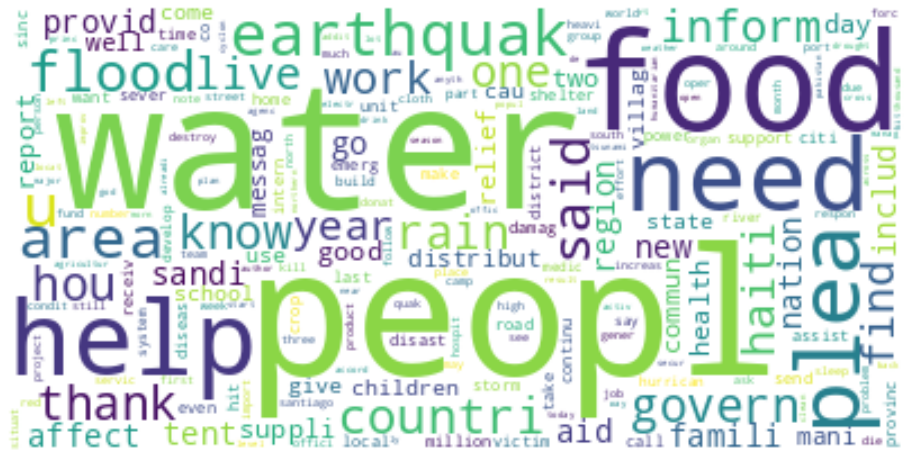

In [ ]:
# Display a word cloud of all the words in the messages
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Joining all the words
text = tokenize(" ".join(i for i in df['message']))
text = " ".join(i for i in text)

# Displaying the word cloud
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()



### 3. Machine Learning Pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. Uses [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) which is helpful for predicting multiple target variables.

In [ ]:
# build a transformer that scales
class OverSamplingTransformer(BaseEstimator, TransformerMixin):
    """A custom transformer to be used in the ML pipeline to handle the class imbalance that is present
    in this dataset.
    """
    
    def __init__(self, n_sample):
        self.n_sample = n_sample
        pass
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        return self
    
    def transform(self, X):
        pass

In [ ]:
# Try other estimators to see if performance is better
# Implement oversampling using SVD of n components

# Number of featurs we want to reduce to so that we can then use this in oversampling transformer
def build_pipeline(n_features=33):
    pipeline = Pipeline([
    ('features', FeatureUnion([
        ('nltk_pipeline', Pipeline([
                ('count-vector', CountVectorizer(tokenizer=tokenize)),
                ('tf-idf', TfidfTransformer())   
        ])),
    ])),
    ('clf', MultiOutputClassifier(RandomForestClassifier(), n_jobs=-1))
    ])
    
    return pipeline

pipeline = build_pipeline()




### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('nltk_pipeline',
                                                 Pipeline(steps=[('count-vector',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x7f403c40b7f0>)),
                                                                 ('tf-idf',
                                                                  TfidfTransformer())]))])),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(),
                                       n_jobs=-1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
col_names = Y.columns.unique()
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=col_names))
    



                        precision    recall  f1-score   support

               related       1.00      1.00      1.00      2310
               request       0.91      0.80      0.85       675
                 offer       0.97      0.85      0.90        72
           aid_related       0.90      0.99      0.95      2008
          medical_help       0.92      0.63      0.75       515
      medical_products       0.98      0.67      0.80       408
     search_and_rescue       0.97      0.66      0.79       266
              security       0.97      0.53      0.69       214
              military       0.91      0.59      0.71       211
                 water       0.93      0.84      0.88       379
                  food       0.95      0.89      0.92       519
               shelter       0.93      0.77      0.84       512
              clothing       0.97      0.77      0.86       151
                 money       0.97      0.59      0.73       174
        missing_people       0.98      

`TODO`: Consider to remove child_alone since there are none of those and also consider oversampling since some of the disaster categories have a low amount of samples.

In [ ]:
# we can consider dropping any columns that have zero rows associated
def drop_columns_with_low_samples():
    for i in df.columns.unique():
        if sum(df[i]) < 200:
            df = df.drop(columns=[i])
        


### 6. Improve your model
Use grid search to find better parameters. 

In [10]:
parameters = {'clf__estimator__n_estimators': [10,50,100,150],
              'clf__n_jobs': [-1], 
              'clf__estimator__n_jobs': [-1]}

cv = GridSearchCV(pipeline, parameters)
cv.fit(X_train, y_train)

NameError: name 'pipeline' is not defined

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred, target_names=col_names))

                        precision    recall  f1-score   support

               related       1.00      1.00      1.00      2310
               request       0.93      0.85      0.89       677
                 offer       1.00      0.72      0.84        68
           aid_related       0.90      0.99      0.94      1974
          medical_help       0.92      0.68      0.78       487
      medical_products       0.98      0.70      0.82       410
     search_and_rescue       0.99      0.68      0.81       305
              security       0.99      0.67      0.80       200
              military       0.98      0.65      0.78       202
                 water       0.98      0.83      0.90       354
                  food       0.96      0.86      0.91       503
               shelter       0.96      0.77      0.85       564
              clothing       0.99      0.75      0.85       166
                 money       0.98      0.66      0.79       190
        missing_people       0.99      

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
# Check what params gridsearchcv has selected
#cv.get_params()
from sklearn.tree import DecisionTreeClassifier
# Trying a different model
def build_pipeline2(classifier):

    pipeline2 = Pipeline([
        ('count-vector', CountVectorizer(tokenizer=tokenize)),
        ('tf-idf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(classifier, n_jobs=-1))
    ])
    
    return pipeline2

def train_pipeline2(pipeline2, X, Y):
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.5, random_state=3)
    
    pipeline2.fit(X_train2, y_train2)
    col_names = Y.columns.unique()
    y_pred2 = pipeline2.predict(X_test2)
    print(classification_report(y_test2, y_pred2, target_names=col_names))
    
pipeline2 = build_pipeline2(DecisionTreeClassifier())
train_pipeline2(pipeline2, X, Y)

                        precision    recall  f1-score   support

               related       1.00      1.00      1.00      3500
               request       0.74      0.78      0.76       997
                 offer       0.58      0.76      0.66       122
           aid_related       0.92      0.92      0.92      3002
          medical_help       0.66      0.71      0.69       734
      medical_products       0.75      0.73      0.74       605
     search_and_rescue       0.60      0.64      0.62       403
              security       0.56      0.59      0.58       285
              military       0.72      0.75      0.73       308
                 water       0.83      0.84      0.83       536
                  food       0.90      0.86      0.88       781
               shelter       0.84      0.78      0.81       805
              clothing       0.84      0.81      0.83       243
                 money       0.66      0.75      0.71       256
        missing_people       0.60      

#### Evaluation of the DecisionTreeClassifier
Trying to DecisionTreeClassifier model it is close in terms of the randomforest model as expected since the random forest classifier is an ensemble method of DecisionTreeClassifier.

In [ ]:
# Trying AdaBoostClassifier model
pipeline2 = build_pipeline2(AdaBoostClassifier())
train_pipeline2(pipeline2, X, Y)


                        precision    recall  f1-score   support

               related       1.00      1.00      1.00      3500
               request       0.80      0.58      0.67       997
                 offer       0.47      0.29      0.36       122
           aid_related       0.89      0.95      0.92      3002
          medical_help       0.72      0.40      0.51       734
      medical_products       0.76      0.44      0.56       605
     search_and_rescue       0.54      0.23      0.33       403
              security       0.47      0.20      0.28       285
              military       0.71      0.42      0.52       308
                 water       0.81      0.80      0.80       536
                  food       0.88      0.78      0.83       781
               shelter       0.82      0.58      0.68       805
              clothing       0.85      0.63      0.72       243
                 money       0.72      0.52      0.60       256
        missing_people       0.66      

#### Evaluation of the AdaBoostClassifier
We can see from the classification report that all our evaluation metrics precision, recall and f1 score are worse with AdaBoostClassifier. Therefore we should go with using RandomForestClassifier.

### 9. Export your model as a pickle file

In [ ]:
# Export the model as a pickle file
joblib.dump(cv, 'classifier.pkl')

['classifier.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [ ]:
model = joblib.load('classifier.pkl')

/home/salman1567/code/Data Science - Machine Learning Projects/Data Science Portfolio/Diasaster Response Classification/env/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/salman1567/code/Data Science - Machine Learning Projects/Data Science Portfolio/Diasaster Response Classification/env/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.war

In [ ]:
model.predict(["".join("we are more than 50 people sleeping on the street. Please hep us find tent, food.")])


array([[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [ ]:
y_test

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
20397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16452,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
13143,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25308,1,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6910,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21432,1,0,0,1,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0
17497,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
22275,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test[0]

'Weather update - a cold front from Cuba that could pass over Haiti'